In [7]:
from model import ml_models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Modify the Hyperparameters

#Modify to change the ratio of training and test data set
HPtest_size = 0.25

#Modify to change the depth limit for the Decision Tree model
HPmax_depth = 20

#Modify to change the solver for the Logistic Regression model
solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
HPsolver = solver_options[2]

#Modify to change the maximum iteration for Logistic Regression model
HPmax_iter = 100

In [9]:
data = pd.read_csv('dataset/Student-Employability-Datasets.csv')
data = data.drop(['Name of Student'], axis=1)
# instantiate label encoder object to encode the target variable
le = LabelEncoder()
# Get the independent features
X = data.iloc[:, :-1]
# Get the dependent features
y = data.iloc[:, -1]
# Encode the target variable
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=HPtest_size, random_state=42)

# create the decision tree model
DT_model = ml_models.DecisionTreeModel(X_train, y_train, max_depth=HPmax_depth, criterion='gini', min_samples_split=2)

# Train the model
DT_model.train()


# Create the logistic regression model
LR_model = ml_models.SimpleLogicalRegression(X=X_train, y=y_train, solver=HPsolver, max_iter=HPmax_iter)

# Train the model
LR_model.train()

# Predict the test data for both models
y_pred_LR = LR_model.predict(X_test)
y_pred_DT = DT_model.predict(X_test)

# Calculate the scores for Logistic Regression
lr_accuracy = accuracy_score(y_test, y_pred_LR)
lr_precision = precision_score(y_test, y_pred_LR)
lr_recall = recall_score(y_test, y_pred_LR)
lr_f1 = f1_score(y_test, y_pred_LR)

# Calculate the scores for Decision Tree
dt_accuracy = accuracy_score(y_test, y_pred_DT)
dt_precision = precision_score(y_test, y_pred_DT)
dt_recall = recall_score(y_test, y_pred_DT)
dt_f1 = f1_score(y_test, y_pred_DT)

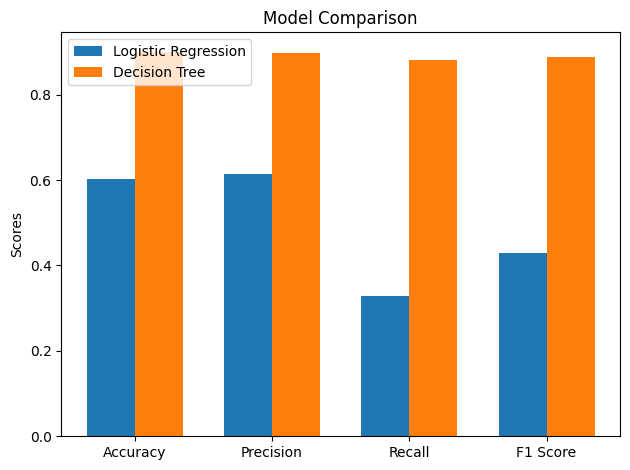

In [10]:
# Predict the test data for both models
y_pred_LR = LR_model.predict(X_test)
y_pred_DT = DT_model.predict(X_test)

# Calculate the scores for Logistic Regression
lr_accuracy = accuracy_score(y_test, y_pred_LR)
lr_precision = precision_score(y_test, y_pred_LR)
lr_recall = recall_score(y_test, y_pred_LR)
lr_f1 = f1_score(y_test, y_pred_LR)

# Calculate the scores for Decision Tree
dt_accuracy = accuracy_score(y_test, y_pred_DT)
dt_precision = precision_score(y_test, y_pred_DT)
dt_recall = recall_score(y_test, y_pred_DT)
dt_f1 = f1_score(y_test, y_pred_DT)

# Create a bar chart to compare the two models
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
logistic_scores = [lr_accuracy, lr_precision, lr_recall, lr_f1]
decision_tree_scores = [dt_accuracy, dt_precision, dt_recall, dt_f1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, logistic_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, decision_tree_scores, width, label='Decision Tree')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

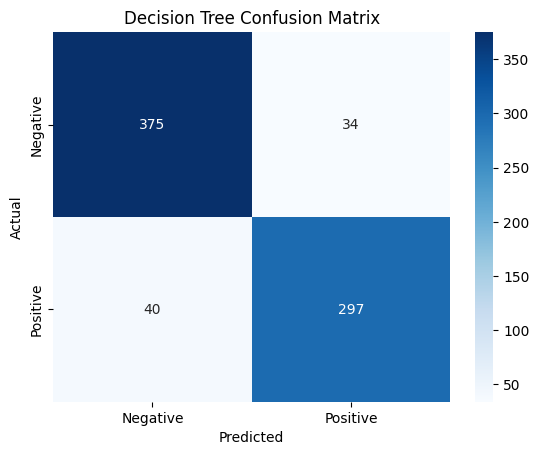

In [11]:
# add the confusion matrix for the decision tree model
dt_cm = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(dt_cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

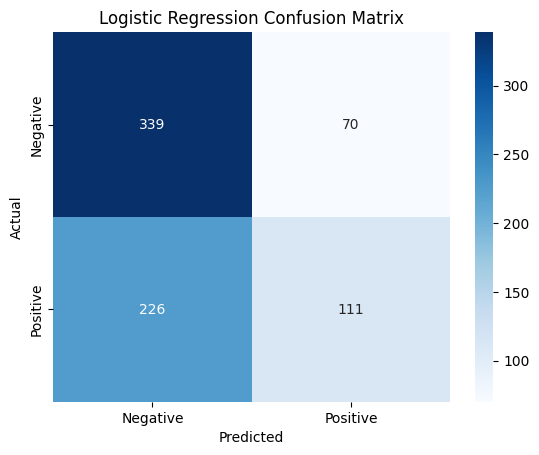

In [12]:
# add the confusion matrix for the logistic regression model
lr_cm = confusion_matrix(y_test, y_pred_LR)
sns.heatmap(lr_cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()